In [51]:
kvasir_path= "/media/mountHDD2/kvasir-capsule-seg"

In [52]:
train_img_dir = kvasir_path+ '/images'
train_1st_mask_dir = kvasir_path+ '/masks'

In [53]:
m = glob.glob(train_1st_mask_dir+'/*')
spm=m[2]
spm

'/media/mountHDD2/kvasir-capsule-seg/masks/131368cc17e44240_28958.jpg'

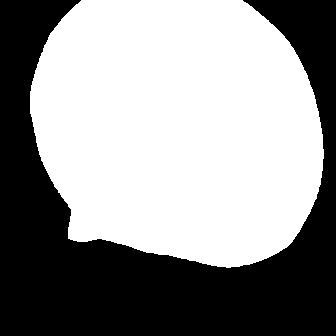

In [54]:
open= Image.open(spm)
open

In [57]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [58]:
from torch.utils.data import Dataset, DataLoader
class Kvasir(Dataset):
    def __init__(self, transform = None, target_transform = None):
        from glob import glob
        self.imgs = sorted(glob(train_img_dir + "/*"))
        self.msks = sorted(glob(train_1st_mask_dir + "/*"))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        msk_path = self.msks[idx]

        img = Image.open(img_path)
        msk = Image.open(msk_path)

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            msk = self.target_transform(msk)

        return (img, msk)

55


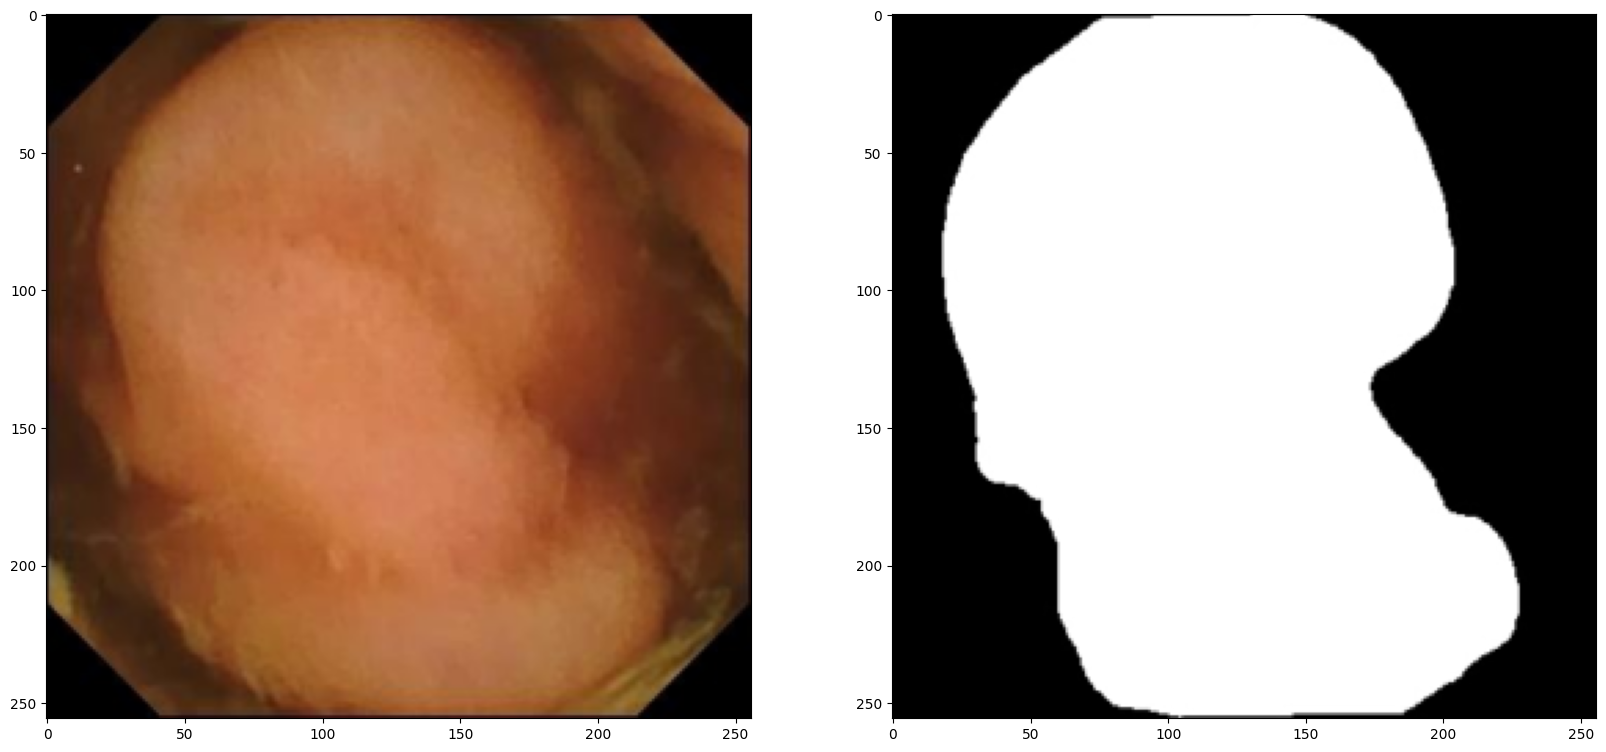

In [59]:
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        #transforms.RandomResizedCrop(size=(224, 224), antialias=True),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), của image net
    ]
)
target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),#####
    ]
)
Data_transfered = Kvasir(transform = transform, target_transform=target_transform)

print(len(Data_transfered ))

img, msk = Data_transfered[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

ax1.imshow(img.permute(1, -1, 0).numpy())
ax2.imshow(msk.permute(1, -1, 0).numpy(), cmap = 'gray')

In [60]:
from torch.utils.data.dataset import random_split
train_ds, test_ds = random_split(Data_transfered, [0.8, 0.2])

train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)

print("Training Samples: {}".format(len(train_ds)))
print("Testing Samples: {}".format(len(test_ds)))

Training Samples: 44
Testing Samples: 11


In [24]:
sample_mask.unique()

tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314,
        0.0353, 0.0392, 0.0431, 0.0471, 0.0549, 0.0588, 0.0627, 0.0667, 0.0706,
        0.0745, 0.0784, 0.0824, 0.0863, 0.0902, 0.0941, 0.0980, 0.1020, 0.1059,
        0.1098, 0.1137, 0.1176, 0.1216, 0.1255, 0.1294, 0.1333, 0.1373, 0.1412,
        0.1451, 0.1490, 0.1529, 0.1569, 0.1608, 0.1647, 0.1725, 0.1765, 0.1804,
        0.1843, 0.1882, 0.1922, 0.1961, 0.2000, 0.2039, 0.2078, 0.2118, 0.2157,
        0.2196, 0.2235, 0.2275, 0.2314, 0.2353, 0.2392, 0.2431, 0.2471, 0.2510,
        0.2549, 0.2588, 0.2627, 0.2667, 0.2706, 0.2745, 0.2784, 0.2824, 0.2863,
        0.2902, 0.2941, 0.3059, 0.3098, 0.3137, 0.3176, 0.3216, 0.3255, 0.3333,
        0.3373, 0.3412, 0.3451, 0.3529, 0.3569, 0.3608, 0.3647, 0.3686, 0.3765,
        0.3843, 0.3882, 0.3922, 0.3961, 0.4000, 0.4039, 0.4078, 0.4118, 0.4157,
        0.4196, 0.4235, 0.4314, 0.4353, 0.4392, 0.4431, 0.4471, 0.4510, 0.4549,
        0.4588, 0.4627, 0.4667, 0.4706, 

In [33]:
type(sample_mask)

torch.Tensor

In [38]:
sample_mask.dim()

3

In [65]:
unique_values1 = sample_mask.unique(dim=1)
unique_values1

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 0.2902],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 0.2902],
         [0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 0.2902]]])

In [70]:
unique_values2 = sample_mask.unique(dim=2)
unique_values2

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [68]:
unique_values0 = sample_mask.unique(dim=0)
unique_values0

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [61]:
sample_data, sample_mask = train_ds[10]

print(f"data shape: {sample_data.shape}")
print(f"mask shape: {sample_mask.shape}")

print(f"Number classes: {np.unique(sample_mask.numpy())}")

data shape: torch.Size([3, 256, 256])
mask shape: torch.Size([1, 256, 256])
Number classes: [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.07450981 0.07843138 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196079 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.1764706  0.18039216 0.18431373 0.1882353
 0.19215687 0.19607843 0.2        0.20784314 0.21176471 0.21568628
 0.21960784 0.22352941 0.22745098 0.23137255 0.23529412 0.23921569
 0.24313726 0.24705882 0.2509804  0.25490198 0.25882354 0.2627451
 0.26666668 0.27058825 0.27450982 0.2784314  0.28235295 0.28627452
 0.2901961  0.29411766 0.3019608  0.30588236 0.30980393 0.3137255
 0.31764707 0.32156864 0.33333334 0.3372

***Training***

In [9]:
class Attention_block(nn.Module): #Module này giúp mô hình tập trung vào các đặc trưng quan trọng trong dữ liệu đầu vào.
    def __init__(self, F_g, F_l, F_int): #Khởi tạo các layer
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x): #Phương thức này thực hiện lan truyền thuận của dữ liệu qua module Attention.
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

In [10]:
class conv_block(nn.Module): #Xây dựng một module gồm hai lớp Convolutional Neural Networks (CNNs) được xếp chồng nhau, mỗi lớp gồm Convolution, Batch Normalization và ReLU.
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x


class up_conv(nn.Module): #Xây dựng một module thực hiện phép Upsampling (tăng kích thước) của đầu vào.
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

In [11]:
class AttU_Net(nn.Module):
    """https://arxiv.org/abs/1804.03999"""
    def __init__(self, img_ch=3, output_ch=3, ini_filter = 16):
        super(AttU_Net, self).__init__()

        n1 = ini_filter
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)        
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out

In [12]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    #Hàm này tính toán hệ số Dice giữa dự đoán (input) và mục tiêu (target),được sử dụng để đánh giá độ tương đồng giữa hai mẫu dữ liệu nhị phân
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    #Hàm này tính toán hệ số Dice đa lớp cho từng lớp trong mô hình. Thường được sử dụng khi có nhiều lớp cần đánh giá
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    #Hàm này tính toán mất mát Dice, là giá trị cần tối thiểu hóa trong quá trình huấn luyện mô hình. Mất mát Dice được tính bằng công thức 1 - hệ số Dic
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)
#device = torch.device("cpu")
model = AttU_Net(img_ch=3, output_ch=1, ini_filter = 16).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

loss_fn = nn.BCEWithLogitsLoss()

In [ ]:
old_loss = 1e26
best_dct = None 
last_dct = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    tr_total_dice = 0
    tr_total_iou = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_loss = loss_fn(train_gen_mask, train_mask)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()        
        
        tr_total_loss += train_loss.cpu().item()        
            
    mean_train_loss = tr_total_loss/len(train_dl)

    if mean_train_loss <= old_loss:
        old_loss = mean_train_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss}")
model.load_state_dict(best_dct)

In [ ]:
torch.save(best_dct, 'parameter_attunet_kvasir_v1.pth')

In [21]:
best_model = AttU_Net(img_ch=3, output_ch=1, ini_filter = 16)
best_model.load_state_dict(torch.load('parameter_attunet_kvasir_v1.pth'))

<All keys matched successfully>

In [18]:
import glob
test_dir='/media/mountHDD2/Kvasir-SEG/images'
test_load = glob.glob(test_dir+'/*')

In [19]:
test_load

['/media/mountHDD2/Kvasir-SEG/images/cju2ycp1u8g2r0799jslnp7cz.jpg',
 '/media/mountHDD2/Kvasir-SEG/images/cju783tmkzkqu081803g7q5vk.jpg',
 '/media/mountHDD2/Kvasir-SEG/images/cju5vxuc5loxw0818u8xgf45p.jpg',
 '/media/mountHDD2/Kvasir-SEG/images/cju2zwg05a0oy0801yr73ig7g.jpg',
 '/media/mountHDD2/Kvasir-SEG/images/cju7ajnbo1gvm098749rdouk0.jpg',
 '/media/mountHDD2/Kvasir-SEG/images/cju30bmab08bi0835mvlr6e0r.jpg',
 '/media/mountHDD2/Kvasir-SEG/images/cju88gx09o2vk0818610zody3.jpg',
 '/media/mountHDD2/Kvasir-SEG/images/cju1d31sp4d4k0878r3fr02ul.jpg',
 '/media/mountHDD2/Kvasir-SEG/images/cjyzk8qieoboa0848ogj51wwm.jpg',
 '/media/mountHDD2/Kvasir-SEG/images/cju7bd1qu1mx409877xjxibox.jpg',
 '/media/mountHDD2/Kvasir-SEG/images/cju8b6rp0r5st0850184f79xt.jpg',
 '/media/mountHDD2/Kvasir-SEG/images/cju2nnqrqzp580855z8mhzgd6.jpg',
 '/media/mountHDD2/Kvasir-SEG/images/cju6x4t13vyw60755gtcf9ndu.jpg',
 '/media/mountHDD2/Kvasir-SEG/images/cju17r8il13910799dr2wme2e.jpg',
 '/media/mountHDD2/Kvasir-SEG/imag

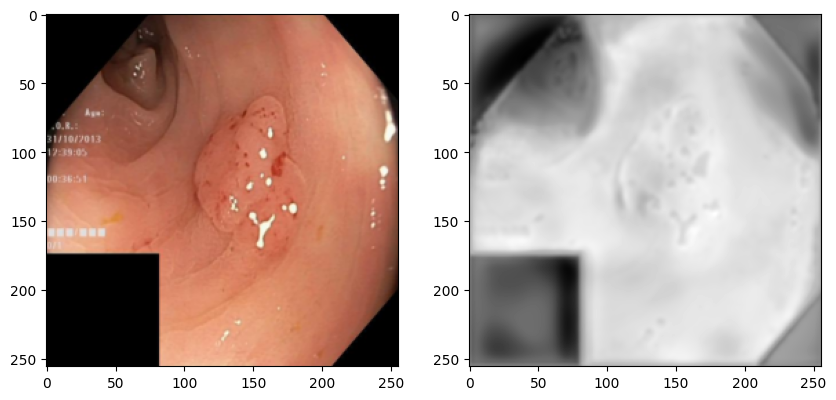

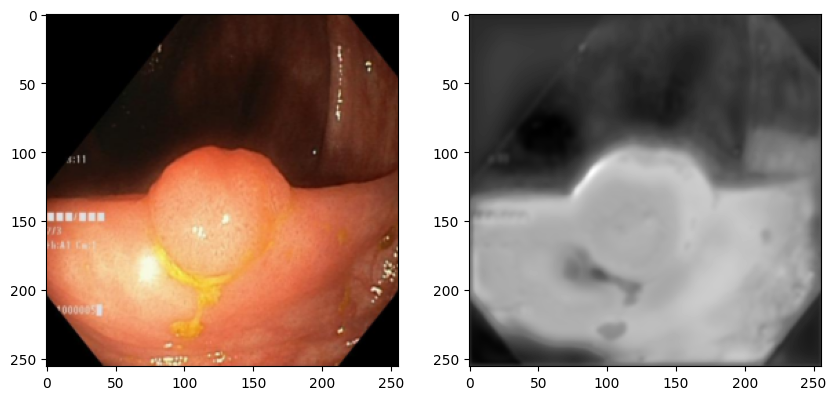

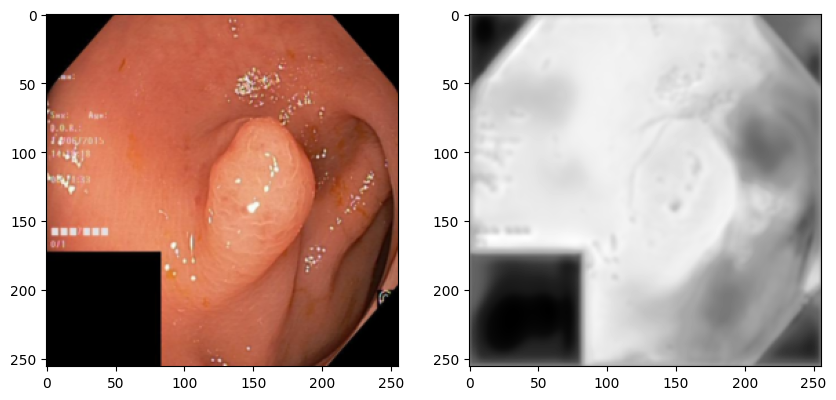

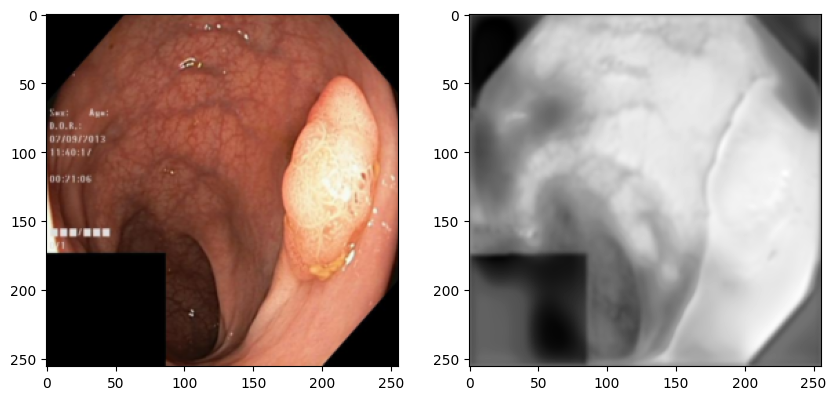

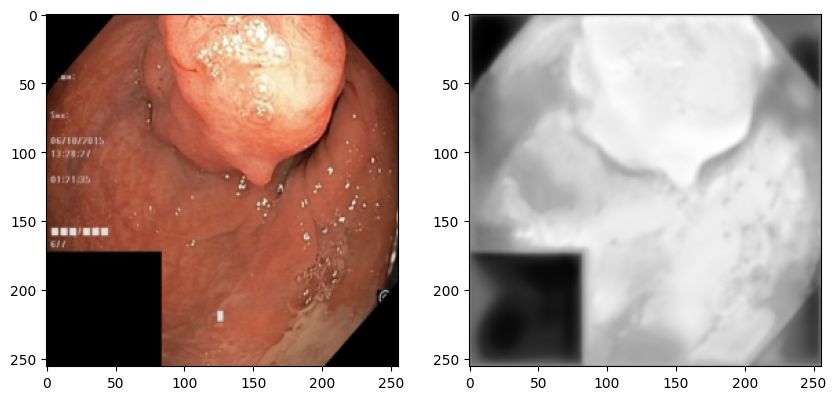

In [23]:
for i in range(5):
    test_image= test_load[i]
    img = transform(Image.open(test_image)).to(device).unsqueeze(0)
    best_model.to(device)
    mask = best_model(img)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    ax1.imshow(img[0].permute(1, -1, 0).detach().cpu().numpy())
    ax2.imshow(mask[0].permute(1, -1, 0).detach().cpu().numpy(), cmap = 'gray')
